In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random

2023-12-28 12:32:03.332259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 12:32:03.678378: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 12:32:03.690229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-28 12:32:03.690277: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

### 1. Image Augmentation

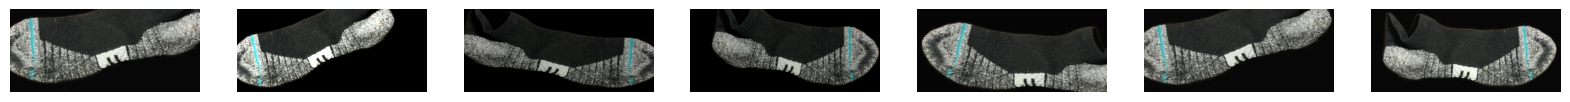

In [2]:
# TODO: Maybe remove rotation later
# TODO: Maybe remove horizontal flip later

np_img = np.array(Image.open("../1Data-Collection/Manual/Centered/IMG_0555.jpg"))
np_img = np_img.reshape(1, np_img.shape[0], np_img.shape[1], np_img.shape[2])

# Augumentation Configuration
roating_range = 20
# width_shift_range = 0.05
# height_shift_range = 0.05
width_shift_range = 0
height_shift_range = 0
brightness_range = [0.5, 1.3]
shear_range = 0
zoom_range = 0.15
channel_shift_range = 10
horizontal_flip = True
vertical_flip = False

datagen = ImageDataGenerator(rotation_range=roating_range, width_shift_range=width_shift_range, height_shift_range=height_shift_range, brightness_range=brightness_range, shear_range=shear_range, zoom_range=zoom_range, channel_shift_range=channel_shift_range, horizontal_flip=horizontal_flip, vertical_flip=vertical_flip)

aug_iter = datagen.flow(np_img, batch_size=1)

# Show augmented images variation
plt.figure(figsize=(20, 20))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.axis("off")
    plt.imshow(aug_iter.next().squeeze().astype(np.uint8))  



In [3]:
def generateAugumentedImages(img, imageCnt = 100):
    aug_iter = datagen.flow(img, batch_size=1)
    images = []

    for i in range(imageCnt):
        images.append(aug_iter.next().astype(np.uint8))
    return np.array(images)

### 2. Prepare the data

In [4]:
def load_images(shape, seed=1234, dataDir="../1Data-Collection/Manual/Centered/"):
  # Get all images
  random.seed(seed)

  images = os.listdir(dataDir)
  random.shuffle(images)
  images = [dataDir + i for i in images]

  # Load to numpy array
  np_images = []
  for i in tqdm(images):
      np_images.append(np.array(Image.open(i).resize(shape)))

  np_images = np.array(np_images).astype(np.float32)

  return np_images

### 3. Transfer Learning

In [10]:
def featureExtractor(model, shape, augCnt, preprocess_input, dataDir="../1Data-Collection/Manual/Centered/"):
  # Load images
  print("\nLoading Images...")
  np_img = load_images(shape, dataDir)

  # Augumentation
  print ("\nAugmenting Images...")
  aug_imgs = []
  for i in tqdm(range(np_img.shape[0])):
    aug_imgs.append(generateAugumentedImages(np.expand_dims(np_img[i], axis=0), augCnt))
  aug_imgs = np.array(aug_imgs)

  print("Augmented Images Shape:", aug_imgs.shape)

  # aug_imgs = preprocess_input(aug_imgs)
  aug_imgs = aug_imgs / 255.0

  # Extract features
  print("\nExtracting Features...")
  features = []
  for i in tqdm(range(aug_imgs.shape[0])):
    features.append(model.predict(aug_imgs[i].squeeze(), verbose=0))
    
  features = np.array(features)
  print("Features Shape:", features.shape)

  return features

### 4. Preparing the extracted features and labels

In [6]:
def split_data(features, split_ratio=0.8, seed=1234):
  # Split data
  random.seed(seed)
  random.shuffle(features)

  split = int(features.shape[0] * split_ratio)

  train = features[:split]
  test = features[split:]

  return train, test

In [7]:
# This function take either train or test data and generate pairs and non-pairs
# TODO: This could be super memory intensive. Maybe we should generate pairs/non-pairs on the fly?
def getTrainTest(data, seed=1234):
  X = []
  y = []

  number_of_pairs = 0

  # Generating Pairs
  print("\nGenerating Pairs...")
  for i in tqdm(range(data.shape[0])): # For each socks
    for j in range(data.shape[1]): # For each augumented images
      for k in range(data.shape[1]): # For each other augumented images
        if j != k:
          X.append([data[i][j], data[i][k]])
          y.append(1)
          number_of_pairs += 1

  # Generating Non-Pairs
  print("\nGenerating Non-Pairs...")

  number_of_non_pairs = 0
  random.seed(seed)

  while number_of_non_pairs != number_of_pairs:
    sock1, sock2 = random.sample(range(data.shape[0]), 2)
    img1, img2 = random.sample(range(data.shape[1]), 2)

    X.append([data[sock1][img1], data[sock2][img2]])
    y.append(0)
    number_of_non_pairs += 1
  
  X = np.array(X)
  y = np.array(y)

  return X, y

### 5. Use pre-trained model as a feature extractor

In [11]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

# Load MobileNetV2
mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [12]:
features = featureExtractor(mobilenet, (224, 224), 2, preprocess_input)


Loading Images...


100%|██████████| 49/49 [00:00<00:00, 173.82it/s]



Augmenting Images...


100%|██████████| 49/49 [00:01<00:00, 24.98it/s]


Augmented Images Shape: (49, 2, 1, 224, 224, 3)

Extracting Features...


100%|██████████| 49/49 [00:11<00:00,  4.23it/s]

Features Shape: (49, 2, 7, 7, 1280)


In [13]:
train, test = split_data(features)
train_X, train_y = getTrainTest(train)
test_X, test_y = getTrainTest(test)

print("Train X Shape:", train_X.shape)
print("Train y Shape:", train_y.shape)
print("Test X Shape:", test_X.shape)
print("Test y Shape:", test_y.shape)


Generating Pairs...


100%|██████████| 39/39 [00:00<00:00, 72251.70it/s]



Generating Non-Pairs...

Generating Pairs...


100%|██████████| 10/10 [00:00<00:00, 36856.80it/s]


Generating Non-Pairs...
Train X Shape: (156, 2, 7, 7, 1280)
Train y Shape: (156,)
Test X Shape: (40, 2, 7, 7, 1280)
Test y Shape: (40,)


### 6. Export data to npy files

In [14]:
np.save("../3ModelTraining/train_X.npy", train_X)
np.save("../3ModelTraining/train_y.npy", train_y)
np.save("../3ModelTraining/test_X.npy", test_X)
np.save("../3ModelTraining/test_y.npy", test_y)